# Chapter 15 - The Random Forest


## Listing 15-1. Importing the data


In [1]:
import pandas as pd

# Read the csv file
data = pd.read_csv("births_data.csv", sep=";")

# Keep useful columns
data = data[["Date", "Births"]]

## Listing 15-2. Feature engineering


In [2]:
data = data.assign(
    Date=pd.to_datetime(data["Date"], dayfirst=True),
    Year=lambda df: df["Date"].dt.year,
    Month=lambda df: df["Date"].dt.month,
).assign(**{f"L{i}": lambda df, i=i: df["Births"].shift(i) for i in range(1, 13)})

## Listing 15-3. Fitting the default Random Forest Regressor


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import mlflow

mlflow.autolog()

# Create X and y object
data = data.dropna()
y = data["Births"]
X = data[
    [
        "Year",
        "Month",
        "L1",
        "L2",
        "L3",
        "L4",
        "L5",
        "L6",
        "L7",
        "L8",
        "L9",
        "L10",
        "L11",
        "L12",
    ]
]

# Create Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=12345, shuffle=False
)

my_rf = RandomForestRegressor()
my_rf.fit(X_train, y_train)
fcst = my_rf.predict(X_test)

print(f"R² Score: {r2_score(list(y_test), list(fcst)):.4f}")

2026/02/23 14:45:01 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2026/02/23 14:45:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.schemas
2026/02/23 14:45:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.tables
2026/02/23 14:45:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.types
2026/02/23 14:45:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.constraints
2026/02/23 14:45:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.defaults
2026/02/23 14:45:02 INFO alembic.runtime.plugins: setup plugin alembic.autogenerate.comments
2026/02/23 14:45:03 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2026/02/23 14:45:03 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2026/02/23 14:45:04 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '19eacec82e254bbe9ccb6599d1c98373', which will track hyperparameters, performance metrics,

R² Score: 0.7536


## Listing 15-4. Fitting the Random Forest Regressor with hyperparameter tuning


### Hyperparameter Tuning Upgrade

**Old:** GridSearchCV (49 combinations)

- Time: ~10 min
- Test R²: 0.7604
- Best: `max_features=0.65`, `n_estimators=500`

**New:** OptunaSearchCV + stagnation early stopping

- Rounded R² scorer (2 decimals)
- Stops after 10 trials without improvement
- Time: ~3 min (13 trials)
- Test R²: 0.7529
- Best: `max_features≈0.687`, `n_estimators=207`

**Why?**

- Much faster (–70%)
- Smarter search + noise reduction via rounding
- Almost same quality, much lower training/prediction cost

**Trade-off:** Minor R² drop (−0.0075) for 3× speed  
→ Worth it for faster iteration


In [ ]:
import optuna
from optuna.integration import OptunaSearchCV
from optuna.exceptions import ExperimentalWarning
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score

import logging
import warnings

# Silence MLflow's chatter
logging.getLogger("mlflow").setLevel(logging.ERROR)

# Silence the specific "UserWarning" about schemas
warnings.filterwarnings("ignore", category=UserWarning, module="mlflow")
warnings.filterwarnings("ignore", category=ExperimentalWarning)

In [ ]:
class StagnationStop:
    def __init__(self, patience=10, decimals=2):
        self.patience = patience
        self.decimals = decimals
        self.wait = 0
        self.best = -float("inf")

    def __call__(self, study, trial):
        if trial.state != optuna.trial.TrialState.COMPLETE:
            return

        value = round(trial.value, self.decimals) if self.decimals else trial.value

        if value > self.best:
            self.best = value
            self.wait = 0
        else:
            self.wait += 1

        if self.wait >= self.patience:
            print(
                f"Stagnation detected: {self.wait} trials no improvement (best={self.best})"
            )
            study.stop()


def rounded_r2(y_true, y_pred):
    return round(r2_score(y_true, y_pred), 2)

In [ ]:
# Optuna uses distributions rather than lists
# This defines the "search space" for the optimizer
param_distributions = {
    "max_features": optuna.distributions.FloatDistribution(0.65, 0.95),
    "n_estimators": optuna.distributions.IntDistribution(10, 1000, log=True),
}

stagnation_cb = StagnationStop(patience=10, decimals=2)

study = optuna.create_study(direction="maximize")

my_rf = OptunaSearchCV(
    estimator=RandomForestRegressor(),
    study=study,
    param_distributions=param_distributions,
    n_trials=20,  # How many configurations to try
    scoring=make_scorer(rounded_r2, greater_is_better=True),
    n_jobs=-1,  # Number of parallel jobs, set to CPU count
    callbacks=[stagnation_cb],
    verbose=1,
)

my_rf.fit(X_train, y_train)

print(f"R² Score: {r2_score(list(y_test), list(my_rf.predict(X_test))):.4f}")
print(f"Best Parameters: {my_rf.best_params_}")

[I 2026-02-23 15:42:29,044] A new study created in memory with name: no-name-804b32c6-2a87-4f2b-bcdd-7f5fec63a75f
[I 2026-02-23 15:42:32,066] Trial 3 finished with value: 0.6960000000000001 and parameters: {'max_features': 0.8100314685809571, 'n_estimators': 11}. Best is trial 3 with value: 0.6960000000000001.
[I 2026-02-23 15:42:32,396] Trial 2 finished with value: 0.712 and parameters: {'max_features': 0.6864881699208214, 'n_estimators': 13}. Best is trial 2 with value: 0.712.
[I 2026-02-23 15:42:32,486] Trial 6 finished with value: 0.696 and parameters: {'max_features': 0.7685528098895644, 'n_estimators': 12}. Best is trial 2 with value: 0.712.
[I 2026-02-23 15:42:36,185] Trial 1 finished with value: 0.724 and parameters: {'max_features': 0.6837339274799519, 'n_estimators': 36}. Best is trial 1 with value: 0.724.
[I 2026-02-23 15:42:38,388] Trial 11 finished with value: 0.68 and parameters: {'max_features': 0.6602991039675702, 'n_estimators': 10}. Best is trial 1 with value: 0.724.


Stagnation detected: 10 trials no improvement (best=0.73)
R² Score: 0.7529
Best Parameters: {'max_features': 0.6873391764120295, 'n_estimators': 207}


## Listing 15-5. Obtaining the plot of the forecast on the test data


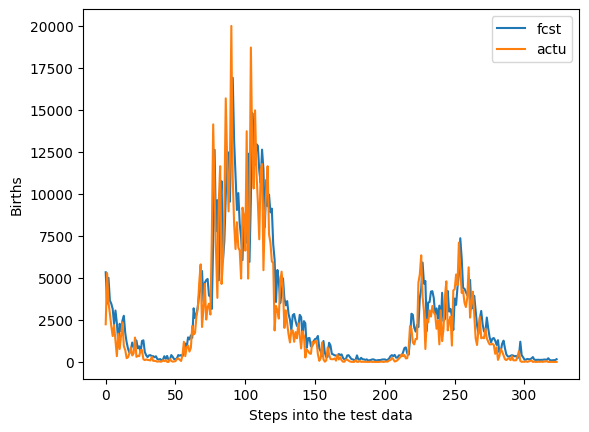

In [12]:
import matplotlib.pyplot as plt

plt.plot(list(fcst))
plt.plot(list(y_test))
plt.legend(["fcst", "actu"])
plt.ylabel("Births")
plt.xlabel("Steps into the test data")
plt.show()

## Listing 15-6. Testing out a normal distribution for the max_features


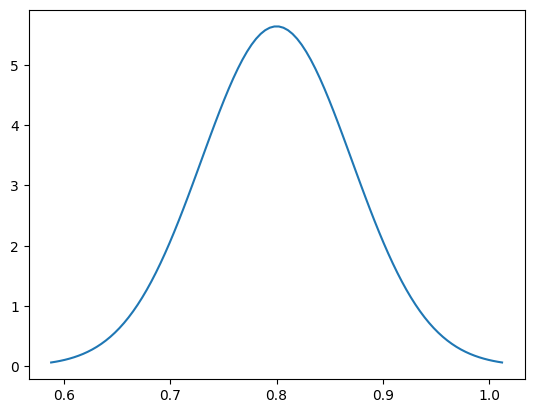

In [13]:
import numpy as np
import scipy.stats as stats
import math

mu = 0.8
variance = 0.005
sigma = math.sqrt(variance)
x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

## Listing 15-7. Testing out a uniform distribution for the n_estimators


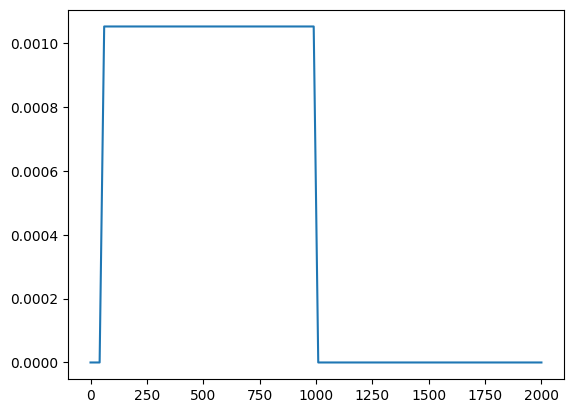

In [14]:
x = np.linspace(0, 2000, 100)
plt.plot(x, stats.uniform.pdf(x, 50, 950))
plt.show()

## Listing 15-8. RandomizedSearchCV with two distributions


## Listing 15-9.Feature Importances


In [15]:
fi = pd.DataFrame(
    {
        "feature": X_train.columns,
        "importance": my_rf.best_estimator_.feature_importances_,
    }
)

fi.sort_values("importance", ascending=False)

,feature,importance
2,L1,0.548277
3,L2,0.196893
4,L3,0.074107
5,L4,0.032174
7,L6,0.018331
6,L5,0.017761
11,L10,0.016545
12,L11,0.015723
10,L9,0.015693
9,L8,0.014543
